## Test top down map generation

### import and params

In [1]:
%cd /home/junting/project_cvl/SceneGraphNav
import argparse
import os 
import habitat_sim
from habitat.utils.visualizations import maps
from habitat_sim.agent.controls.controls import SceneNodeControl
import open3d as o3d
import numpy as np
from dataset.habitat.simulator import init_sim 
from plyfile import PlyData, PlyElement

# local import 
from scene_graph.config import SceneGraphHabitatConfig



scene_error = ['HxpKQynjfin', '29hnd4uzFmX']
scene_empty_map = ['fzynW3qQPVF']


def parse_args(input=""):

    parser = argparse.ArgumentParser()
    parser.add_argument("--scan_dir", type=str, default="/media/junting/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans")
    parser.add_argument("--scene_name", type=str, default="HxpKQynjfin") # 17DRP5sb8fy
    parser.add_argument("--dataset", type=str, default="matterport")
    
    parser.add_argument("--visualize", type=int, default=1)
    parser.add_argument("--vis_mode", type=str, default="segment", choices=["rgb", "segment"])
    
    parser.add_argument("--rel_dist_thresh", type=float, default=2.0, help="threshold of max distance between two objects that could have a relationship")

    args = parser.parse_args(input)  
    args.scene_ply_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_semantic.ply')
    args.scene_glb_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}.glb')
    args.pclseg_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_pclseg.txt')
    args.pcl_normals_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}_normals.npy')
    args.house_file_path = os.path.join(args.scan_dir, args.scene_name, f'{args.scene_name}.house')
    return args 


/home/junting/project_cvl/SceneGraphNav
pybullet build time: Sep 22 2020 00:56:01
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### utility functions 

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)
    
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

### initialize simulator and load ground truth scene graph 

In [3]:
############ initialize habitat simulator and ground truth scene graph ########
args = parse_args()
sim, action_names, sim_settings = init_sim(args.scene_glb_path)

I0305 10:45:39.215893 566520 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I0305 10:45:39.215910 566520 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I0305 10:45:39.215972 566520 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I0305 10:45:39.216002 566520 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
I0305 10:45:39.216033 566520 AssetAttributesManager.cpp:120] Asset attributes (coneSolid : coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTange

Renderer: NVIDIA GeForce RTX 3080/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 470.103.01
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits
agent_state: position [0. 0. 0.] rotation quaternion(1, 0, 0, 0)
sensor_states: {'rgb': SixDOFPose(position=array([0. , 1.5, 0. ], dtype=float32), rotation=quaternion(1, 0, 0, 0)), 'depth': Si

/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans/HxpKQynjfin/HxpKQynjfin.navmesh
I0305 10:45:39.303016 566520 Simulator.cpp:213] ::setSceneInstanceAttributes : Loading navmesh from /media/junting/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans/HxpKQynjfin/HxpKQynjfin.navmesh
I0305 10:45:39.303109 566520 Simulator.cpp:216] ::setSceneInstanceAttributes : Navmesh Loaded.
I0305 10:45:39.303118 566520 SceneGraph.h:85] Created DrawableGroup: 
I0305 10:45:39.303122 566520 Simulator.cpp:251] ::setSceneInstanceAttributes : SceneInstance : /media/junting/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans/HxpKQynjfin/HxpKQynjfin.glb proposed Semantic Scene Descriptor filename : /media/junting/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans/HxpKQynjfin/HxpKQynjfin.house
W0305 10:45:39.335850 566520 Simulator.cpp:275] ::setSceneInstanceAttributes : All attempts to load SSD with SceneAttributes-provided name /media/junting/SSD_data/habitat_data/scene_datasets/mp3d/v1/scans/HxpKQynjfin/HxpKQ

In [4]:
%reload_ext autoreload
import sys
from importlib import reload

# del sys.modules['scene_graph.scene_graph_cls'] 
from scene_graph import scene_graph_cls
from scene_graph.config import SceneGraphHabitatConfig

# intialize ground truth scene graph 
config = SceneGraphHabitatConfig()
sg = scene_graph_cls.SceneGraphHabitat(config, scene_name=args.scene_name)
sg.load_gt_scene_graph(args.scene_ply_path, args.pclseg_path, args.pcl_normals_path, sim) 

 38%|███▊      | 3/8 [00:00<00:00, 17.12it/s]

100%|██████████| 8/8 [00:00<00:00, 18.27it/s]


### generate a path

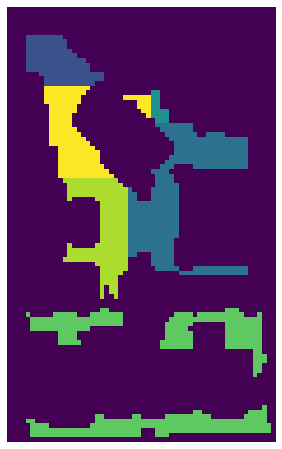

start point [ 0.70878999 -0.39017501  0.19014707] 
end point [1.87888   1.0055702 0.87124  ] , not navigable, snapped to [1.87888    0.00982499 0.87124   ]


In [5]:
from scene_graph.utils import grid_xz_to_points
seed = 4  # @param {type:"integer"}
sim.pathfinder.seed(seed)

region_id = sg.region_layer.region_ids[0]
region_node = sg.region_layer.region_dict[region_id]
grid_map = region_node.grid_map
idx_arr = np.argwhere(grid_map)

if True:
    # grid_map = region_node.grid_map
    # display_map(grid_map)
    segment_grid = sg.region_layer.segment_grid
    display_map(segment_grid)

# NOTE: (row_idx, col_idx) corresponds to (y, x) in 2d grid map 
# need to swap the column in idx_arr
region_free_space_points = grid_xz_to_points(sg.scene_bounds, idx_arr[:,[1,0]], 
    sg.height, sg.meters_per_grid)

# 1. clip starting point & target object position to closest valid navigable point 
start = region_free_space_points[0,:] # first point 
object_id = sg.object_layer.obj_ids[0]
object_node = sg.object_layer.obj_dict[object_id]
end = object_node.center

start_exact = sim.pathfinder.is_navigable(start)
if not start_exact:
    start_snapped = sim.pathfinder.snap_point(start)
snap_info = "" if start_exact else f", not navigable, snapped to {start}"
print(f"start point {region_free_space_points[0,:]}", snap_info)

end_exact = sim.pathfinder.is_navigable(end)
if not end_exact:
    end = sim.pathfinder.snap_point(end)
snap_info = "" if end_exact else f", not navigable, snapped to {end}"
print(f"end point {object_node.center}", snap_info)

### Test how height impacts fetched map 

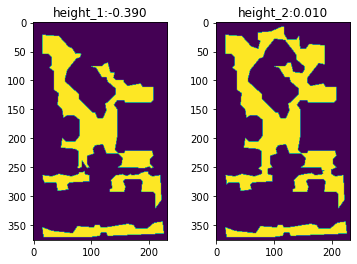

In [ ]:
# test how height affects map  
meters_per_pixel = 0.025
scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb
# option 1: use scene bounding box bottom 
height_1 = scene_bb.y().min 

# option 2: use random navigable point 
nav_point = sim.pathfinder.get_random_navigable_point()
height_2 = nav_point[1]

# # first method to get map, from habitat-lab
# top_down_map = maps.get_topdown_map(
#             sim.pathfinder, height, meters_per_pixel=meters_per_pixel
#         )
# # second method to get map, from habitat-sim 
top_down_map_1 = sim.pathfinder.get_topdown_view(
    meters_per_pixel=meters_per_pixel, height=height_1
).astype(np.uint8)

top_down_map_2 = sim.pathfinder.get_topdown_view(
    meters_per_pixel=meters_per_pixel, height=height_2
).astype(np.uint8)

DISPLAY_THIS = True
if DISPLAY_THIS:
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    ax1.imshow(top_down_map_1)
    ax2.imshow(top_down_map_2)
    
    ax1.set_title(f"height_1:{height_1:.3f}")
    ax2.set_title(f"height_2:{height_2:.3f}")
    
    plt.show()

In [ ]:
# # show navmesh map with changing of heights on a height grid 
# num_grid = 10
# layout = (2,5)
# figsize=(10,10) # width, height 

# height_grids = np.linspace(scene_bb.y().min, scene_bb.y().max, num=num_grid)
# # height_grids = np.linspace(scene_bb.y().min, 1.0, num=num_grid)
# fig, axes = plt.subplots(*layout, constrained_layout=True, figsize=figsize)
# axes = axes.reshape(-1)
# for i, height in enumerate(height_grids):
#     top_down_map = sim.pathfinder.get_topdown_view(
#         meters_per_pixel=meters_per_pixel, height=height
#     ).astype(np.uint8)
    
#     # ax = plt.subplot(*layout, i+1)
#     ax = axes[i]
#     ax.imshow(top_down_map)
#     ax.set_title(f"height_{i+1}:{height:.3f}")
# fig.suptitle(f'Free space map generated from Navmesh file of scene {args.scene_name}', fontsize=16)
# plt.show()

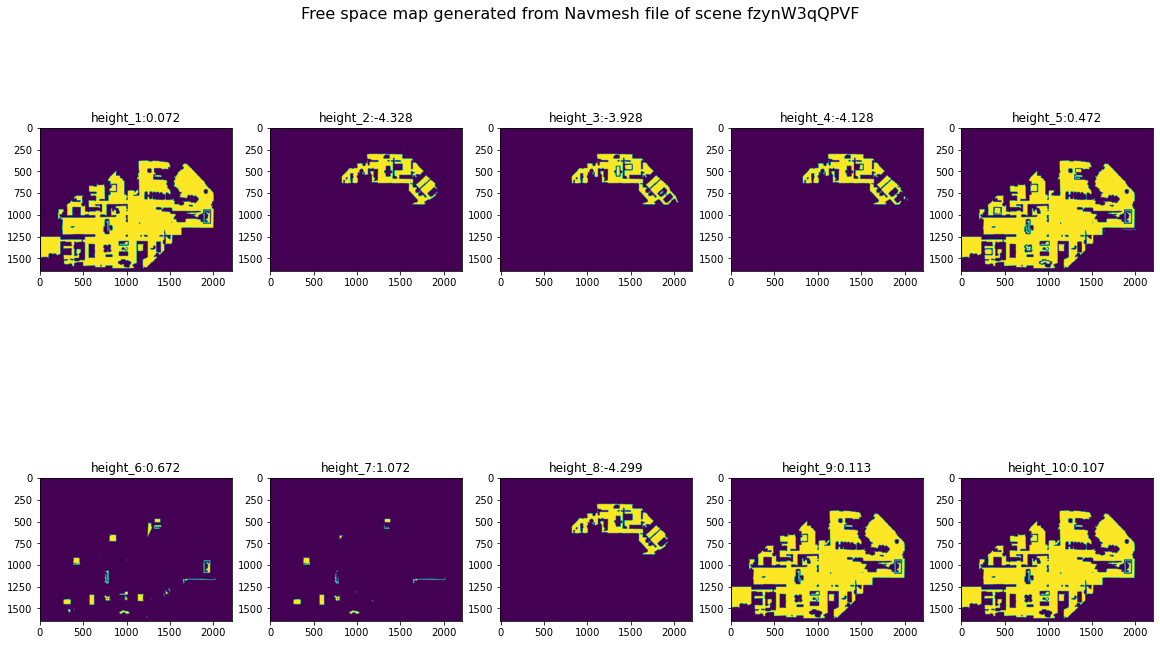

In [ ]:
# show navmesh map with changing of heights randomly sampled from navigable points 
# count heights and sort by number free space points 
heights = []
for _ in range(1000):
    nav_point = sim.pathfinder.get_random_navigable_point()
    heights.append(nav_point[1])
    
heights, counts = np.unique(heights, return_counts=True)
sort_idx = np.argsort(-counts)
counts = counts[sort_idx]
heights = heights[sort_idx]
    
num_display = 10
layout = (2,5)
figsize=(16,10) # width, height 
    
# height_grids = np.linspace(scene_bb.y().min, 1.0, num=num_grid)
fig, axes = plt.subplots(*layout, constrained_layout=True, figsize=figsize)
axes = axes.reshape(-1)
for i, height in enumerate(heights[:num_display]):
    top_down_map = sim.pathfinder.get_topdown_view(
        meters_per_pixel=meters_per_pixel, height=height
    ).astype(np.uint8)
    
    # ax = plt.subplot(*layout, i+1)
    ax = axes[i]
    ax.imshow(top_down_map)
    ax.set_title(f"height_{i+1}:{height:.3f}")
fig.suptitle(f'Free space map generated from Navmesh file of scene {args.scene_name}', fontsize=16)
plt.show()

In [ ]:
# @markdown 2. Use ShortestPath module to compute path between samples.
path = habitat_sim.ShortestPath()
path.requested_start = start
path.requested_end = end
found_path = sim.pathfinder.find_path(path)
geodesic_distance = path.geodesic_distance
path_points = path.points
# @markdown - Success, geodesic path length, and 3D points can be queried.
print("found_path : " + str(found_path))
print("geodesic_distance : " + str(geodesic_distance))
print("path_points : " + str(path_points))



found_path : True
geodesic_distance : 4.158048152923584
path_points : [array([ 0.70879   , -0.390175  ,  0.19014707], dtype=float32), array([ 1.40879   ,  0.20982501, -0.50985295], dtype=float32), array([ 1.85879   ,  0.20982501, -0.45985293], dtype=float32), array([2.35879   , 0.20982501, 0.19014704], dtype=float32), array([2.7087898 , 0.20982501, 0.69014704], dtype=float32), array([2.7087898 , 0.20982501, 0.840147  ], dtype=float32), array([2.60879   , 0.20982501, 0.9901471 ], dtype=float32), array([2.2087898 , 0.00982499, 0.94014716], dtype=float32), array([1.87888   , 0.00982499, 0.87124   ], dtype=float32)]



Display the map with agent and path overlay:


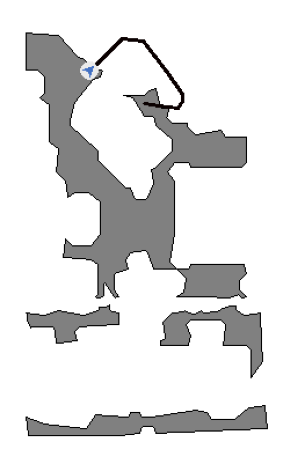

In [ ]:
# @markdown 3. Display trajectory (if found) on a topdown map of ground floor

display=True
import imageio
import magnum as mn
import math

if found_path:
    # meters_per_pixel = 0.025
    meters_per_pixel = 0.025
    scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb
    height = scene_bb.y().min
    if display:
        top_down_map = maps.get_topdown_map(
            sim.pathfinder, height, meters_per_pixel=meters_per_pixel
        )
        recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        top_down_map = recolor_map[top_down_map]
        grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
        # convert world trajectory points to maps module grid points
        trajectory = [
            maps.to_grid(
                path_point[2],
                path_point[0],
                grid_dimensions,
                pathfinder=sim.pathfinder,
            )
            for path_point in path_points
        ]
        grid_tangent = mn.Vector2(
            trajectory[1][1] - trajectory[0][1], trajectory[1][0] - trajectory[0][0]
        )
        path_initial_tangent = grid_tangent / grid_tangent.length()
        initial_angle = math.atan2(path_initial_tangent[0], path_initial_tangent[1])
        # draw the agent and trajectory on the map
        maps.draw_path(top_down_map, trajectory)
        maps.draw_agent(
            top_down_map, trajectory[0], initial_angle, agent_radius_px=8
        )
        print("\nDisplay the map with agent and path overlay:")
        display_map(top_down_map)

    

In [ ]:
path_points

[array([ 0.70879   , -0.390175  ,  0.19014707], dtype=float32),
 array([ 1.40879   ,  0.20982501, -0.50985295], dtype=float32),
 array([ 1.85879   ,  0.20982501, -0.45985293], dtype=float32),
 array([2.35879   , 0.20982501, 0.19014704], dtype=float32),
 array([2.7087898 , 0.20982501, 0.69014704], dtype=float32),
 array([2.7087898 , 0.20982501, 0.840147  ], dtype=float32),
 array([2.60879   , 0.20982501, 0.9901471 ], dtype=float32),
 array([2.2087898 , 0.00982499, 0.94014716], dtype=float32),
 array([1.87888   , 0.00982499, 0.87124   ], dtype=float32)]

Rendering observations at path points:


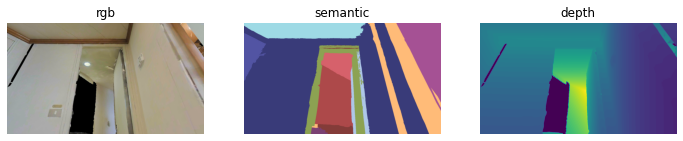

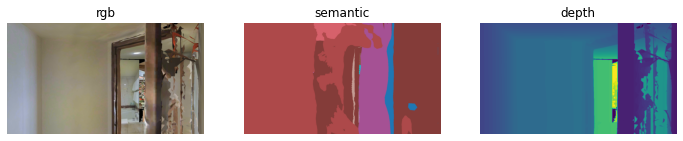

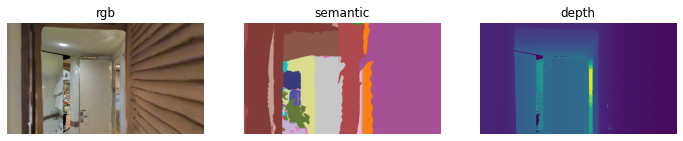

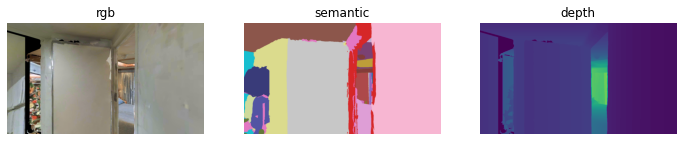

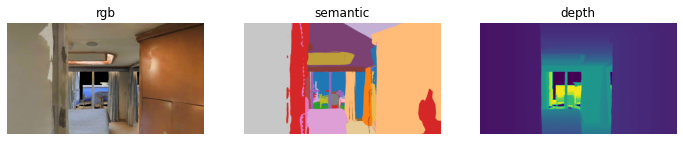

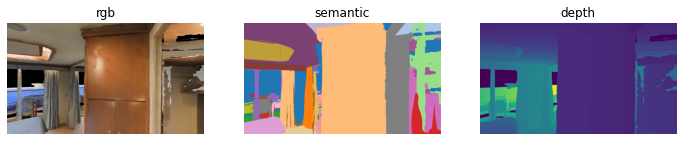

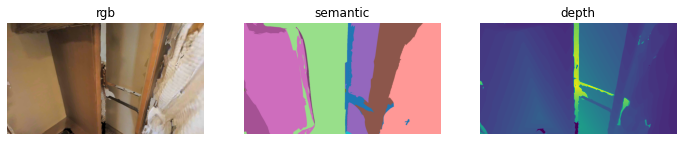

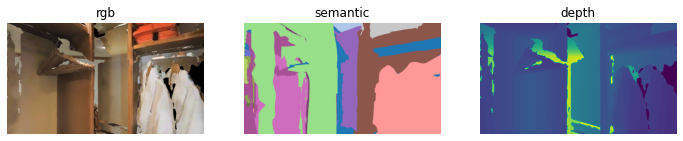

In [ ]:
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

# @markdown 4. (optional) Place agent and render images at trajectory points (if found).
display_path_agent_renders = True  # @param{type:"boolean"}
if display_path_agent_renders:
    print("Rendering observations at path points:")
    tangent = path_points[1] - path_points[0]
    agent_state = habitat_sim.AgentState()
    for ix, point in enumerate(path_points):
        if ix < len(path_points) - 1:
            tangent = path_points[ix + 1] - point
            agent_state.position = point
            tangent_orientation_matrix = mn.Matrix4.look_at(
                point, point + tangent, np.array([0, 1.0, 0])
            )
            tangent_orientation_q = mn.Quaternion.from_matrix(
                tangent_orientation_matrix.rotation()
            )
            agent_state.rotation = utils.quat_from_magnum(tangent_orientation_q)
            agent = sim.get_agent(0)
            agent.set_state(agent_state)

            observations = sim.get_sensor_observations()
            rgb = observations["rgb"]
            semantic = observations["semantic"]
            depth = observations["depth"]

            if display:
                display_sample(rgb, semantic, depth)

In [ ]:
observations.keys()

### extra: load scene annots

In [ ]:
from dataset.habitat.utils import read_house_file

house_dict, parse_dict = read_house_file(args.house_file_path)

In [ ]:
house_dict['H']

### extra: load gt shortest path 

In [8]:
import json 
import gzip 

task_dir = "/media/junting/SSD_data/habitat_data/datasets/objectnav/mp3d/v1"
split = 'train'
annot_dir = os.path.join(task_dir, split, 'content')
annot_files = sorted(os.listdir(annot_dir))
task_meta_file = os.path.join(task_dir, split, 'train.json.gz')

In [12]:
annot_file = f'{args.scene_name}.json.gz'
with gzip.open(os.path.join(annot_dir, annot_file), 'r') as json_file:
    scene_task_data = json.loads(json_file.read().decode('utf-8'))

In [25]:
print(scene_task_data.keys())
# print(scene_task_data['goals_by_category']['HxpKQynjfin.glb_table'][0])
HxpKQynjfin_glb_table = scene_task_data['goals_by_category']['HxpKQynjfin.glb_table'][0]
print(HxpKQynjfin_glb_table.keys())
# print(HxpKQynjfin_glb_table['object_id'])
print(scene_task_data['episodes'][0])

dict_objectid2goal = {
    goal['object_id']: goal
    for cat in scene_task_data['goals_by_category'].keys()
    for goal in scene_task_data['goals_by_category'][cat]
}

dict_keys(['goals_by_category', 'episodes', 'category_to_task_category_id', 'category_to_mp3d_category_id'])
dict_keys(['position', 'radius', 'object_id', 'object_name', 'object_category', 'room_id', 'room_name', 'view_points'])
{'episode_id': '0', 'scene_id': 'mp3d/HxpKQynjfin/HxpKQynjfin.glb', 'start_position': [1.02115, 0.00982, 5.58634], 'start_rotation': [0, 0.92732, 0, -0.37428], 'info': {'geodesic_distance': 4.7014, 'euclidean_distance': 4.36715, 'closest_goal_object_id': 7, 'navigation_bounds': [[-1.09121, -0.39018, -1.20985], [4.72718, 4.35705, 8.21466]], 'best_viewpoint_position': [2.46476, 0.0643, 1.39807]}, 'goals': [], 'start_room': None, 'shortest_paths': [[2, 2, 2, 2, 1, 2, 2, 2, 1, 3, 3, 3, 3, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 3, 3, 3, 1, 3, 3, 1, 2, 1, 1, 2, 2, 1, 2, 1, None]], 'object_category': 'clothes'}


In [31]:
init_positions = []
init_heights = []
for episode in scene_task_data['episodes']:
    init_positions.append(episode['start_position'][1])
    init_heights.append(episode['start_position'][1])
    
heights, counts = np.unique(init_heights, return_counts=True)
sort_idx = np.argsort(-counts)
counts = counts[sort_idx]
heights = heights[sort_idx]
print({heights[i]:counts[i]
    for i in range(len(heights))
})

{0.00982: 24338, 0.20982: 21802, 0.0702: 4, 0.01534: 3, 0.0324: 3, 0.11019: 3, 0.01781: 2, 0.0496: 2, 0.01844: 2, 0.13877: 2, 0.07029: 2, 0.04898: 2, 0.04859: 2, 0.01716: 2, 0.07094: 2, 0.07095: 2, 0.13736: 2, 0.03578: 2, 0.04806: 2, 0.04778: 2, 0.08613: 2, 0.01481: 2, 0.09085: 2, 0.01873: 2, 0.06916: 2, 0.03844: 2, 0.06089: 2, 0.16038: 2, 0.10296: 2, 0.10588: 2, 0.10795: 2, 0.0237: 2, 0.09598: 2, 0.03134: 2, 0.05393: 2, 0.0536: 2, 0.14465: 2, 0.06655: 2, 0.05256: 2, 0.02088: 2, 0.06747: 2, 0.06748: 2, 0.03298: 2, 0.01897: 2, 0.07518: 2, 0.02739: 2, 0.01159: 2, 0.07891: 2, 0.01042: 2, 0.01024: 2, 0.04316: 2, 0.07635: 2, 0.01086: 2, 0.0442: 2, 0.01015: 2, 0.08342: 2, 0.04094: 2, 0.12306: 1, 0.10781: 1, 0.12375: 1, 0.12272: 1, 0.12359: 1, 0.10803: 1, 0.10816: 1, 0.12348: 1, 0.10826: 1, 0.11083: 1, 0.10862: 1, 0.10879: 1, 0.12336: 1, 0.1088: 1, 0.10929: 1, 0.10963: 1, 0.12335: 1, 0.11075: 1, 0.11039: 1, 0.11003: 1, 0.11008: 1, 0.12327: 1, 0.1231: 1, 0.12293: 1, 0.11038: 1, 0.11031: 1, 0.1